# Build predictive model to assess feature importance

This code will build a predictive model to assess feature importance. The label of the users is from step 2, result of clustering users. The features used in this model includes user demography from 'userinfo.csv' and third party health data from smartphones and smart watches. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Build-predictive-model-to-assess-feature-importance" data-toc-modified-id="Build-predictive-model-to-assess-feature-importance-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Build predictive model to assess feature importance</a></span><ul class="toc-item"><li><span><a href="#Data-pre-processing" data-toc-modified-id="Data-pre-processing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data pre-processing</a></span><ul class="toc-item"><li><span><a href="#Load-third-party-health-data-and-extract-features" data-toc-modified-id="Load-third-party-health-data-and-extract-features-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Load third party health data and extract features</a></span></li><li><span><a href="#Get-user-demography-data" data-toc-modified-id="Get-user-demography-data-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Get user demography data</a></span></li><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Prepare data</a></span></li></ul></li><li><span><a href="#Machine-Learning" data-toc-modified-id="Machine-Learning-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Machine Learning</a></span><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#naive_bayes" data-toc-modified-id="naive_bayes-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>naive_bayes</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Logistic regression</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>SVM</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import datetime
import tsfresh.utilities.dataframe_functions
from sklearn import preprocessing
from tsfresh import select_features
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

## Data pre-processing

### Load third party health data and extract features

In [3]:
#Access third party data stored as postgresql database in AWS
#Since third party health data is more than 600M rows, it is stored in AWS.
#I removed the information of the database for privacy reasons.
dbname = ''
username = '' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database="",
    user="",
    password="",
    host="",
    port='')

# query:
sql_query = """
SELECT "owner", "type", "startDate","value" FROM public."DataSample"
where "startDate" >'2019-08-01 00:00:00.000+00'
AND "startDate" < '2019-09-20 00:00:00.000+00'
;
"""
sql_result = pd.read_sql_query(sql_query,con).set_index('startDate')
sql_result = sql_result.sort_index()

In [4]:
#For security reason, I cannot show the details of the third party health data
#The third-party health data is time series data. 
#So I also use tsfresh to extract features from the data
third_party = extract_features(sql_result, column_id="owner", column_value='value', column_kind='type', default_fc_parameters=MinimalFCParameters())

### Get user demography data

In [7]:
#Load user label result from step 2.
user_label = pd.read_csv('user_label_PCA.csv',index_col = [0])

In [43]:
#Get user demography from 'userinfo.csv'
userinfo = pd.read_csv('userinfo.csv')
userinfo.rename(columns={'_id':'id'},inplace=True)
userinfo.head()

,id,role,mainTrack,biography,gender,dateOfBirth,bioHeight,bioWeight,location,provider,...,statFollowingCount,community,prefShareGoal,prefShareCommunityStats,prefShareCommunityActivity,prefShareSessionActivity,prefShareWorkoutActivity,prefNotificationCommunityLike,prefNotificationCommunityResponse,prefNotificationCommunityMutualResponse
0,00000000-57f4-181e-b125-0c32bf5d1202,user,NaN,NaN,NaN,NaN,NaN,NaN,NaN,local,...,NaN,ongo,t,t,t,f,f,t,t,t
1,00000000-5858-6c36-569d-1f09932b560d,user,NaN,NaN,male,1987-01-01 08:00:00+00,NaN,63.503007,NaN,local,...,0.0,ongo,t,t,t,f,f,t,t,t
2,00000000-593a-e4b9-f150-88505f883858,user,00000000-584a-71f6-6bec-e05d49e87120,NaN,test,1988-01-01 08:00:00+00,NaN,NaN,NaN,local,...,0.0,ongo,t,t,t,f,f,t,t,t
3,00000000-57f4-3b69-b125-0c32bf5d1206,user,NaN,NaN,female,NaN,NaN,NaN,NaN,local,...,NaN,ongo,t,t,t,f,f,t,t,t
4,00000000-5875-7c2a-74b9-7f1caea30755,user,NaN,NaN,male,1995-10-21 07:00:00+00,NaN,122.470086,NaN,facebook,...,0.0,ongo,t,t,t,f,f,t,t,t


In [47]:
#Get gender information.
userinfo['gender'].unique()

array([nan, 'male', 'test', 'female', 'hi hi ', 'TestGender', 'hi', 'hey',
       'testing', 'asdf', 'f', 'Unicorn', 'Male', 'Female', 'other',
       'rad human ', '🙋🏻\u200d♂️'], dtype=object)

In [48]:
#The input of gender is variable. I have to clean the data for further analysis.
userinfo['gender'] = userinfo['gender'].fillna('unknown')
userinfo['gender'] = userinfo['gender'].replace('Female','female')
userinfo['gender'] = userinfo['gender'].replace('Male','male')
userinfo['gender'] = userinfo['gender'].replace('f','female')
userinfo['gender'] = userinfo['gender'].replace('TestGender','unknown')
userinfo['gender'] = userinfo['gender'].replace('Unicorn','unknown')
userinfo['gender'] = userinfo['gender'].replace('asdf','unknown')
userinfo['gender'] = userinfo['gender'].replace('hey','unknown')
userinfo['gender'] = userinfo['gender'].replace('hi','unknown')
userinfo['gender'] = userinfo['gender'].replace('hi hi ','unknown')
userinfo['gender'] = userinfo['gender'].replace('other','unknown')
userinfo['gender'] = userinfo['gender'].replace('rad human ','unknown')
userinfo['gender'] = userinfo['gender'].replace('test','unknown')
userinfo['gender'] = userinfo['gender'].replace('testing','unknown')
userinfo['gender'] = userinfo['gender'].replace('🙋🏻‍♂️','unknown')
userinfo['gender'].groupby(userinfo['gender']).count()

gender
female      246
male        228
unknown    7167
Name: gender, dtype: int64

In [10]:
#Get the age of users from date of birth.
userinfo['dateOfBirth'] = pd.to_datetime(userinfo['dateOfBirth'])
now = pd.Timestamp('now')
def age(date):
    return now.year - date.year
userinfo['age'] = userinfo['dateOfBirth'].apply(age)

### Prepare data

In [11]:
# The total features for the model includes features from third party health data and demography
demography = userinfo[['id','gender','provider','age']]
total_feature = pd.merge(third_party,demography,on='id',how='left')

In [14]:
#Not all users have third party health data. 
#For this model, we only predict users with third party health data.
labels = user_label[user_label['id'].isin(total_feature['id'])]
total_feature = total_feature[total_feature['id'].isin(labels['id']) ]

In [17]:
#Convert categorical variable into dummy/indicator variables for classification
features = pd.get_dummies(total_feature)
#Use impute function in tsfresh package to replace all NaNs and infs from the dataframe.
feature_class = tsfresh.utilities.dataframe_functions.impute(features) 
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit data on the scaler object
scaled_df = scaler.fit_transform(feature_class)
names = feature_class.columns
scaled_df = pd.DataFrame(scaled_df, columns=names)
#Filter features using select_features function in tsfresh package.
#Select_feature function checks the significance of all features of feature matrix X 
#and return a possibly reduced feature matrix only containing relevant features.
features_filtered = select_features(scaled_df, label)

In [49]:
#There are much more users in cluster 0 than cluster 1. It is an imbalanced data.
label.value_counts()

0    1107
1     369
Name: clusters, dtype: int64

In [30]:
#Downsample the majority to have better performance in predicting models.
#I tried several ratios for down sampling. This ratio performs the best.
label = label1.reset_index()
features_filtered = features_filtered.reset_index()
df_t = pd.merge(features_filtered,label,on='id',how='outer')

# separate minority and majority classes
cluster0 = df_t[df_t['clusters']==0]
cluster1 = df_t[df_t['clusters']==1]

# Downsample majority
cluster0_upsampled = resample(cluster0,
                          replace=True, # sample with replacement
                          n_samples=len(cluster1)*2, # match number in minority class
                          random_state=27) # reproducible results

# combine downsampled majority and minority
df_new = pd.concat([cluster1, cluster0_upsampled])
#Imbalance data - resample
df_new['clusters'].value_counts()
features_filtered = df_new.drop(['clusters'],axis =1)
label = df_new[['id','clusters']]
label = label.set_index(label.columns[0])
features_filtered = features_filtered.set_index(features_filtered.columns[0])
label = pd.Series(label['clusters'])

## Machine Learning

Among all the models I tried, Random Forest performs the best. So I use it to further assess feature importance. The reason that random forest performs the best is that I have an imbalanced data, and random forest is an ensemble of decision trees. Each decision tree overfit the imbalanced data in a different way, so through voting those differences are averaged out.

### Random Forest

In [31]:
#Split the data to have 80% data for training and 20% data for testing
X_train, X_test, y_train, y_test = train_test_split(features_filtered, label, test_size=.2)

In [33]:
# Construct machine learning model using random forest
#Create a random forest Classifier
forest = RandomForestClassifier(n_estimators= 150, max_features='auto')
#Train the model using the training sets
forest.fit(X_train, y_train)
print('Training accuracy:', np.mean(forest.predict(X_train) == y_train)*100)
print('Test accuracy:', np.mean(forest.predict(X_test) == y_test)*100)

Training accuracy: 99.91525423728814
Test accuracy: 84.45945945945947


In [34]:
#Measure confusion matrix and calculate precision, recall f1-score and support
#Recall of cluster 1 is pretty low, since it is imbalanced data.
print(confusion_matrix(y_test, forest.predict(X_test)))
print(classification_report(y_test, forest.predict(X_test)))

[[218   4]
 [ 42  32]]
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       222
           1       0.89      0.43      0.58        74

    accuracy                           0.84       296
   macro avg       0.86      0.71      0.74       296
weighted avg       0.85      0.84      0.82       296



[[218   4]
 [ 42  32]]


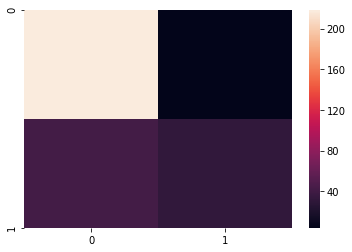

In [35]:
# Visualise classical Confusion M0atrix
CM = confusion_matrix(y_test, forest.predict(X_test))
# Visualize it as a heatmap
seaborn.heatmap(CM)
plt.show()

Text(0.5, 1.0, 'Feature importance using Random Forest Model')

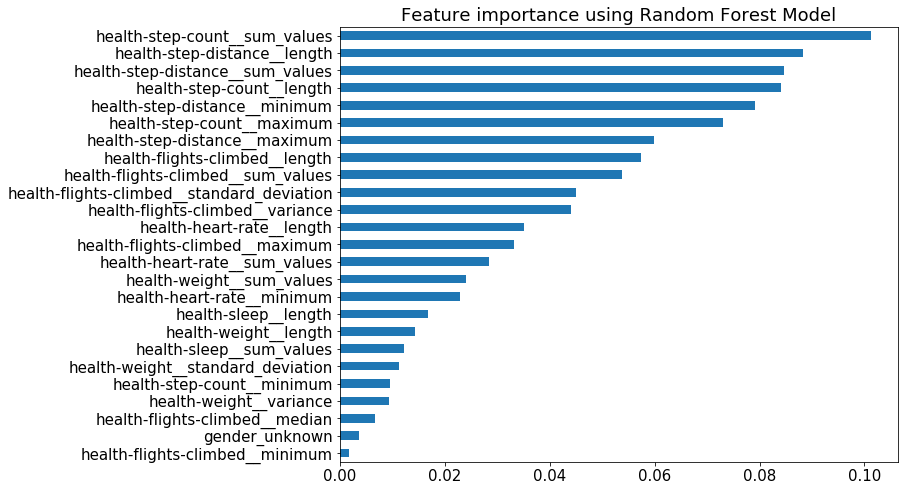

In [38]:
#Calculate feature importance
importance_vals = forest.feature_importances_
coef = pd.Series(importance_vals, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
matplotlib.rc('font', size=15)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Random Forest Model")

Now when a new user log in the app and the company get the third party health data of the users, company can send customized notifications according to the values of the important features to potential low-activity users to optimize their engagement.

### naive_bayes

In [53]:
#Create a Gaussian Classifier
gnb = GaussianNB()
#Train the model using the training sets
gnb.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [54]:
#Import scikit-learn metrics module for accuracy calculation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 85 141]
 [ 14  56]]
              precision    recall  f1-score   support

           0       0.86      0.38      0.52       226
           1       0.28      0.80      0.42        70

    accuracy                           0.48       296
   macro avg       0.57      0.59      0.47       296
weighted avg       0.72      0.48      0.50       296



### Logistic regression

In [56]:
#Create a logistic regression Classifier
logreg = LogisticRegression()
#Train the model using the training sets
logreg.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.7736


In [57]:
#Import scikit-learn metrics module for accuracy calculation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[199  27]
 [ 40  30]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       226
           1       0.53      0.43      0.47        70

    accuracy                           0.77       296
   macro avg       0.68      0.65      0.66       296
weighted avg       0.76      0.77      0.77       296



### XGBoost

In [64]:
#Create a XGBoost Classifier
model = XGBClassifier()
#Train the model using the training sets
x = model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
#Import scikit-learn metrics module for accuracy calculation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[209  17]
 [ 37  33]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       226
           1       0.66      0.47      0.55        70

    accuracy                           0.82       296
   macro avg       0.75      0.70      0.72       296
weighted avg       0.80      0.82      0.81       296



### SVM

In [66]:
##Create a Gaussian Kernel Classifier
svclassifier = SVC(kernel='rbf')
#Train the model using the training sets
svclassifier.fit(X_train, y_train)
# make predictions for test data
y_pred = svclassifier.predict(X_test)

/Users/zhenruzhou/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [67]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[218   8]
 [ 44  26]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       226
           1       0.76      0.37      0.50        70

    accuracy                           0.82       296
   macro avg       0.80      0.67      0.70       296
weighted avg       0.82      0.82      0.80       296

